<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/Explainable-Ai-for-The-ML-Models/blob/main/TRestNet50%20XAi%20tecniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
pip install tensorflow keras numpy matplotlib


In [26]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import files
from sklearn.utils.class_weight import compute_class_weight

In [27]:
from google.colab import drive  # <-- Import drive
drive.mount('/content/drive') # Mount to the default path without spaces

# Now access your dataset using the full path:
train_dir = "/content/drive/MyDrive/Dataset4/Training"
validation_dir = "/content/drive/MyDrive/Dataset4/Validation"
test_dir = "/content/drive/MyDrive/Dataset4/Testing"  # If needed for testing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# train_dir = "./Dataset4/Training"
# validation_dir = "./Dataset4/Validation"
# test_dir = "./Dataset4/Testing"  # If needed for testing


In [29]:
# Image dimensions
height = 300
width = 300
batch_size = 8


In [30]:
# Load ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

In [31]:
# Data

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,  # Add shear
    zoom_range=0.2,   # Add zoom
    brightness_range=[0.8, 1.2]  # Add brightness variation
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
 # Added test data generator

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 64 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Found 6 images belonging to 3 classes.


In [32]:
# Add custom layers to ResNet50
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [33]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# # Callbacks
# checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [37]:
model.fit(
    train_generator,
    validation_data=train_generator,
    epochs=12,
    # callbacks=[checkpoint, early_stopping],
    class_weight=class_weights  # Add class weights
)

Epoch 1/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 18s/step - accuracy: 0.5065 - loss: 0.6969 - val_accuracy: 0.5000 - val_loss: 6.4018
Epoch 2/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - accuracy: 0.6533 - loss: 0.7102 - val_accuracy: 0.4531 - val_loss: 1.3052
Epoch 3/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - accuracy: 0.5311 - loss: 0.7293 - val_accuracy: 0.5000 - val_loss: 1.2567
Epoch 4/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - accuracy: 0.5780 - loss: 0.6525 - val_accuracy: 0.4531 - val_loss: 4.0973
Epoch 5/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 15s/step - accuracy: 0.5089 - loss: 1.3665 - val_accuracy: 0.5938 - val_loss: 1.5129
Epoch 6/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 161s 18s/step - accuracy: 0.5116 - loss: 0.8058 - val_accuracy: 0.6250 - val_loss: 1.0232
Epoch 7/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - accuracy: 0.5094 - loss: 0.7583 - val_accuracy: 0.5312 - val_loss: 0.9714
Epoch 8/12
8/8 ━━━━━━━━━━━━━━━━━━━━ 133s 17s/step - accuracy: 0.4852 - loss: 0.7251 - val_accuracy: 0.5156 - val_loss:

In [38]:
# Save the final model
model.save("resnet50_model.h5")
print("Model training complete and saved as resnet50_model.h5")

Model training complete and saved as resnet50_model.h5


In [45]:
test_loss, test_acc = model.evaluate(train_generator)
print(f"Test Accuracy: {test_acc:.2%}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5952 - loss: 0.6500
Test Accuracy: 59.38%


In [50]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img_path = "/content/drive/MyDrive/Dataset4/Training/Fake/2000_f1.jpg"  # Corrected path
img = image.load_img(img_path, target_size=(300, 300))  # Match model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Apply same preprocessing as training

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)  # Get class index
class_labels = list(train_generator.class_indices.keys())  # Get class names
print(f"Predicted Class: {class_labels[predicted_class]}")  # Print the class label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Predicted Class: Real


In [51]:
!pip install lime


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image


In [52]:
def explain_with_lime(img_path, model):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(300, 300))  # Match model input size
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0,1]

    # Create a LIME Explainer
    explainer = lime_image.LimeImageExplainer()

    # Define a function to predict probabilities
    def model_predict(images):
        images = np.array([image.img_to_array(image.array_to_img(img, scale=False)) for img in images])
        images = preprocess_input(images)  # Apply same preprocessing as training
        return model.predict(images)

    # Explain the prediction
    explanation = explainer.explain_instance(
        img_array,
        model_predict,
        top_labels=1,    # Explain the most important class
        hide_color=0,
        num_samples=500  # Number of perturbed samples
    )

    # Get image mask
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,  # Number of important regions to highlight
        hide_rest=True
    )

    # Display the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Original Image")

    # Display the LIME Explanation
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis("off")
    plt.title("LIME Explanation")

    plt.show()


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

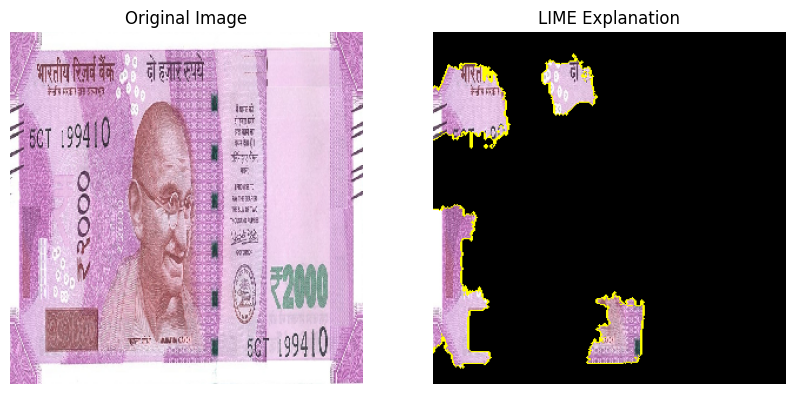

In [53]:
img_path = "/content/drive/MyDrive/Dataset4/Training/Fake/2000_f1.jpg"  # Change this to your actual image
explain_with_lime(img_path, model)


Found 64 images belonging to 2 classes.


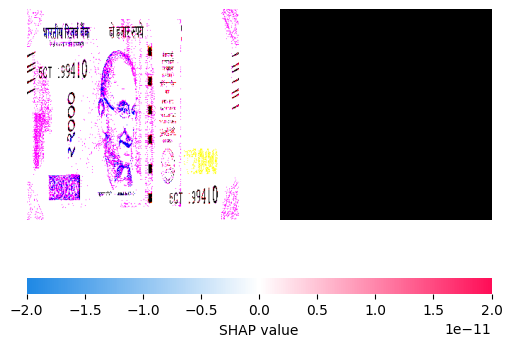

In [74]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

# ✅ Use DeepExplainer instead of PermutationExplainer
def explain_with_shap(img_path, model, background_generator):
    """
    Explain a ResNet50 classification using SHAP.

    Parameters:
        img_path (str): Path to the image for explanation.
        model (keras.Model): The trained ResNet50 model.
        background_generator: A data generator to get background images.
    """
    # ✅ Step 1: Load & Preprocess the Image (Consistent with ResNet50)
    img = image.load_img(img_path, target_size=(300, 300))  # Match model input size
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Apply ResNet50 preprocessing

    # ✅ Step 2: Get Background Images for SHAP
    background_samples, _ = next(background_generator)  # Get a batch of images
    background_samples = preprocess_input(background_samples)  # Apply ResNet50 preprocessing

    # ✅ Step 3: Use DeepExplainer for SHAP (Better for Neural Networks)
    explainer = shap.DeepExplainer(model, background_samples)

    # ✅ Step 4: Explain the Image
    shap_values = explainer.shap_values(img_array)  # Compute SHAP values

    # ✅ Step 5: Visualize SHAP Explanation
    shap.image_plot(shap_values, img_array)  # Display SHAP heatmap

# ✅ Use a Small Batch from Training Data as Background
background_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=10,  # Use 10 real images as background
    class_mode='categorical'
)

# ✅ Test SHAP on a Fake Currency Note Image
img_path = "/content/drive/MyDrive/Dataset4/Training/Fake/2000_f1.jpg"  # Change as needed
explain_with_shap(img_path, model, background_generator)


In [ ]:
#------------SHAP TECNIQUE--------
# Install required libraries
!pip install shap tensorflow keras numpy matplotlib

In [83]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

# # ✅ Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# ✅ Define image preprocessing function
def preprocess_img(img_path):
    """Loads an image and preprocesses it for the model."""
    img = image.load_img(img_path, target_size=(300, 300))  # Match ResNet input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Apply ResNet50 preprocessing
    return img_array

# ✅ Load your trained model
model_path = "/content/resnet50_model.h5"  # Update if saved elsewhere
model = tf.keras.models.load_model(model_path)

# ✅ Create a background dataset for SHAP (using random training images)
background_paths = [
    "/content/drive/MyDrive/Dataset4/Training/Real/2000_s1.jpg",
    "/content/drive/MyDrive/Dataset4/Training/Fake/500_f6.jpg",
    "/content/drive/MyDrive/Dataset4/Training/Real/500_s3.jpg",
    "/content/drive/MyDrive/Dataset4/Training/Fake/2000_f3.jpg"
]  # Replace with real paths

background_samples = np.vstack([preprocess_img(p) for p in background_paths])

# ✅ Use SHAP's GradientExplainer (better for CNNs)
explainer = shap.GradientExplainer(model, background_samples)

# ✅ Select a test image for SHAP analysis
img_path = "/content/drive/MyDrive/Dataset4/Training/Fake/2000_f1.jpg"  # Change as needed
img_array = preprocess_img(img_path)

# ✅ Get SHAP values
shap_values = explainer.shap_values(img_array)



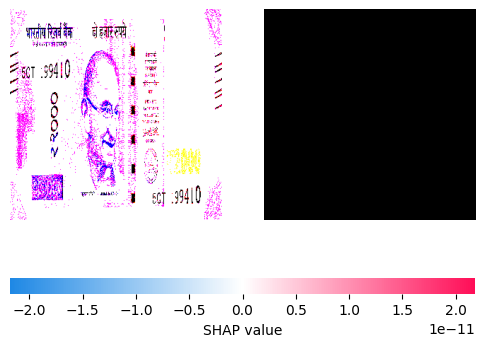

In [84]:

# ✅ Visualize SHAP heatmap
shap.image_plot(shap_values, img_array)

In [ ]:
# Install required libraries
!pip install tensorflow numpy opencv-python matplotlib

In [85]:
#--------------GRAD-CAM XAi TECHNIQUE----------



import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

# # ✅ Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# ✅ Load your trained ResNet model
model_path = "/content/resnet50_model.h5"  # Update if saved elsewhere
model = tf.keras.models.load_model(model_path)

# ✅ Get the last convolutional layer in ResNet50
last_conv_layer_name = "conv5_block3_out"  # Change if using a different model

# ✅ Function to preprocess an image
def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(300, 300))  # Match ResNet input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# ✅ Function to apply Grad-CAM
def grad_cam(img_path, model, last_conv_layer_name):
    """Generates a Grad-CAM heatmap for a given image and model."""

    img_array = preprocess_img(img_path)

    # Create a model that outputs both final predictions and last conv-layer activations
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients of the top predicted class
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])  # Get the predicted class index
        loss = predictions[:, class_idx]

    # Get gradients of the loss w.r.t. last conv layer output
    grads = tape.gradient(loss, conv_output)

    # Compute channel-wise importance weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply importance weights with conv layer activations
    conv_output = conv_output[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # ✅ Overlay heatmap on original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (300, 300))  # Match input size

    # Convert heatmap to RGB
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend heatmap with image
    overlay = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

    # ✅ Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()




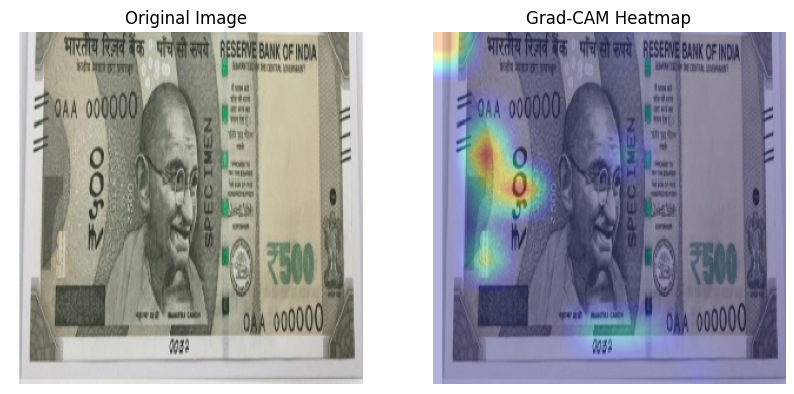

In [86]:
# ✅ Test Grad-CAM on a Fake Currency Note Image
img_path = "/content/drive/MyDrive/Dataset4/Training/Fake/14.jpg"  # Change as needed
grad_cam(img_path, model, last_conv_layer_name)